In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def square_distance(src, dst):
    return torch.sum((src[:, :, None] - dst[:, None]) ** 2, dim=-1)

def farthest_point_sample(xyz, npoint):
    B, N, _ = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long)
    distance = torch.ones(B, N) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[torch.arange(B), farthest].unsqueeze(1)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def index_points(points, idx):
    B = points.shape[0]
    S = idx.shape[1]
    return points[torch.arange(B)[:, None], idx]

def query_ball_point(radius, nsample, xyz, new_xyz):
    sqrdists = square_distance(new_xyz, xyz)  # (B, S, N)
    group_idx = sqrdists.argsort()[:, :, :nsample]
    return group_idx

def sample_and_group(npoint, radius, nsample, xyz, points):
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)
    new_xyz = index_points(xyz, fps_idx)
    group_idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, group_idx) - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, group_idx)
        new_points = torch.cat([grouped_xyz, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz

    return new_xyz, new_points

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp_channels):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        layers = []
        last_channel = in_channel + 3  # on ajoute les coordonnées x,y,z
        for out_channel in mlp_channels:
            layers.append(nn.Conv2d(last_channel, out_channel, 1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
            last_channel = out_channel
        self.mlp = nn.Sequential(*layers)

    def forward(self, xyz, points):
        new_xyz, grouped_points = sample_and_group(
            self.npoint, self.radius, self.nsample, xyz, points
        )
        # grouped_points : (B, S, nsample, C)
        new_points = grouped_points.permute(0, 3, 2, 1)  # (B, C, nsample, S)
        new_points = self.mlp(new_points)  # (B, C', nsample, S)
        new_points = torch.max(new_points, 2)[0]  # maxpool sur nsample → (B, C', S)
        return new_xyz, new_points.permute(0, 2, 1)  # → (B, S, 3), (B, S, C')



In [27]:
def three_nn_interpolate(xyz1, xyz2, points2):
    dists = torch.cdist(xyz1, xyz2, p=2)
    dists, idx = torch.topk(dists, 3, dim=-1, largest=False, sorted=False)
    dist_recip = 1.0 / (dists + 1e-8)
    norm = torch.sum(dist_recip, dim=2, keepdim=True)
    weight = dist_recip / norm
    interpolated = torch.sum(index_points(points2, idx) * weight.unsqueeze(-1), dim=2)
    return interpolated

class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super().__init__()
        layers = []
        last_channel = in_channel
        for out_channel in mlp:
            layers.append(nn.Conv1d(last_channel, out_channel, 1))
            layers.append(nn.BatchNorm1d(out_channel))
            layers.append(nn.ReLU())
            last_channel = out_channel
        self.mlp = nn.Sequential(*layers)

    def forward(self, xyz1, xyz2, points1, points2):
        interpolated_points = three_nn_interpolate(xyz1, xyz2, points2)
        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points
        return self.mlp(new_points.permute(0, 2, 1)).permute(0, 2, 1)


In [28]:
class PointNet2SemSeg(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.sa1 = PointNetSetAbstraction(1024, 0.1, 32, 0, [32, 32, 64])
        self.sa2 = PointNetSetAbstraction(256, 0.2, 32, 64, [64, 64, 128])
        self.sa3 = PointNetSetAbstraction(64, 0.4, 32, 128, [128, 128, 256])

        self.fp3 = PointNetFeaturePropagation(384, [256, 128])
        self.fp2 = PointNetFeaturePropagation(192, [128, 64])
        self.fp1 = PointNetFeaturePropagation(64, [64, 64, 64])

        self.classifier = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.Dropout(0.5),
            nn.Conv1d(64, num_classes, 1)
        )

    def forward(self, xyz):  # (B, N, 3)
        B, N, _ = xyz.shape
        l0_points = None
        l0_xyz = xyz

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        out = self.classifier(l0_points.permute(0, 2, 1))  # (B, C, N)
        return out.permute(0, 2, 1)  # (B, N, C)


In [29]:
import numpy as np

def load_npz_pointcloud(file_path, remap={-1: 0, 0: 1, 174: 2}):
    arr = np.load(file_path)
    pts = arr["lidar_points"].astype(np.float32)
    labels = arr["lidar_category"].astype(np.int32)
    mask = np.isin(labels, list(remap.keys()))
    pts = pts[mask]
    labels = labels[mask]
    labels = np.vectorize(remap.get)(labels)
    return torch.tensor(pts).unsqueeze(0), torch.tensor(labels).unsqueeze(0)


In [30]:
model = PointNet2SemSeg(num_classes=3)
model.eval()

file = "../data/moon/1692601824140114944.npz"
xyz, gt = load_npz_pointcloud(file)
xyz = xyz[:, :2048, :]
gt = gt[:, :2048]

with torch.no_grad():
    pred = model(xyz)
    pred_labels = pred.argmax(dim=-1)
    acc = (pred_labels == gt).float().mean().item()

print(f"✅ Fichier : {file}")
print(f"🎯 Précision brute : {acc:.4f}")


✅ Fichier : ../data/moon/1692601824140114944.npz
🎯 Précision brute : 0.8696


In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pointcloud(xyz, labels, title=""):
    xyz = xyz.squeeze().numpy()
    labels = labels.squeeze().numpy()
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=labels, cmap='tab10', s=1)
    ax.set_title(title)
    plt.show()


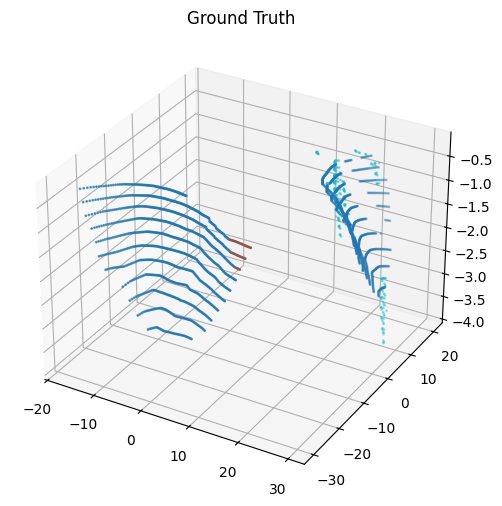

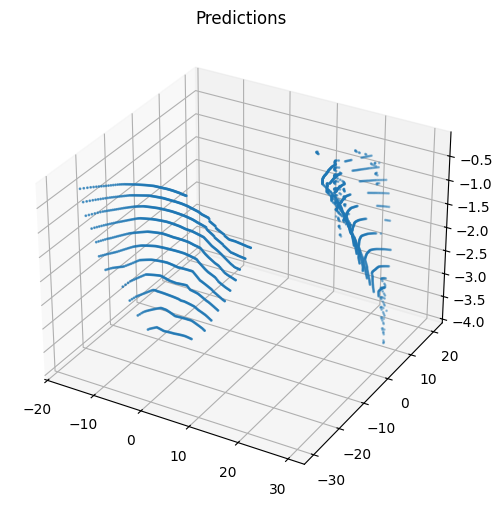

In [32]:
plot_pointcloud(xyz, gt, "Ground Truth")
plot_pointcloud(xyz, pred_labels, "Predictions")


In [46]:
import os
from tqdm import tqdm

def batch_test_folder(folder_path, model, remap={-1: 0, 0: 1, 174: 2}, max_points=2048, crop_ratio=0):
    model.eval()
    all_scores = []
    failures = []

    files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]
    files = files[:int(len(files)*(1-crop_ratio))]
    
    for f in tqdm(files, desc="🔍 Évaluation"):
        path = os.path.join(folder_path, f)
        try:
            xyz, gt = load_npz_pointcloud(path, remap)
            if xyz.shape[1] > max_points:
                xyz = xyz[:, :max_points, :]
                gt = gt[:, :max_points]

            with torch.no_grad():
                pred = model(xyz)
                pred_labels = pred.argmax(dim=-1)
                acc = (pred_labels == gt).float().mean().item()

            all_scores.append(acc)
            if acc < 0.5:
                failures.append((f, acc))
        except Exception as e:
            print(f"❌ Erreur fichier {f}: {e}")

    mean_acc = np.mean(all_scores)
    print(f"\n✅ Fichiers évalués : {len(all_scores)}")
    print(f"🎯 Précision moyenne : {mean_acc:.4f}")

    if failures:
        print(f"\n⚠️  Fichiers avec acc < 0.5 : {len(failures)}")
        for f, acc in sorted(failures, key=lambda x: x[1])[:3]:
            print(f" - {f}: acc = {acc:.4f}")

    return all_scores


In [48]:
folder = "../data/moon"
scores = batch_test_folder(folder, model, crop_ratio=0.95)


🔍 Évaluation: 100%|██████████| 239/239 [02:04<00:00,  1.91it/s]


✅ Fichiers évalués : 239
🎯 Précision moyenne : 0.7578


In [55]:
import torch
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def compute_iou(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            ious.append(np.nan)  # on ignore cette classe
        else:
            ious.append(intersection / union)
    return ious

def batch_iou_test(folder_path, model, remap={-1: 0, 0: 1, 174: 2}, max_points=2048, num_classes=3, crop_ratio=0):
    model.eval()
    iou_sums = np.zeros(num_classes)
    iou_counts = np.zeros(num_classes)
    total_seen = np.zeros(num_classes)
    total_correct = np.zeros(num_classes)
    total_union = np.zeros(num_classes)

    files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]
    files = files[:int(len(files)*(1-crop_ratio))]
    
    for f in tqdm(files, desc="🔬 Calcul IoU"):
        path = os.path.join(folder_path, f)
        try:
            xyz, gt = load_npz_pointcloud(path, remap)
            if xyz.shape[1] > max_points:
                xyz = xyz[:, :max_points, :]
                gt = gt[:, :max_points]

            with torch.no_grad():
                pred = model(xyz).argmax(dim=-1)

            gt_np = gt.squeeze().numpy()
            pred_np = pred.squeeze().numpy()

            for cls in range(num_classes):
                gt_cls = (gt_np == cls)
                pred_cls = (pred_np == cls)
                intersection = np.logical_and(gt_cls, pred_cls).sum()
                union = np.logical_or(gt_cls, pred_cls).sum()

                if union > 0:
                    iou_sums[cls] += intersection / union
                    iou_counts[cls] += 1

                total_seen[cls] += (gt_np == cls).sum()
                total_correct[cls] += np.logical_and(gt_cls, pred_cls).sum()
                total_union[cls] += union

        except Exception as e:
            print(f"❌ Fichier échoué : {f} → {e}")

    class_iou = iou_sums / (iou_counts + 1e-8)
    mean_iou = np.nanmean(class_iou)

    print("\n📈 IoU par classe :")
    for i, score in enumerate(class_iou):
        print(f"  Classe {i} → IoU = {score:.4f} (sur {int(iou_counts[i])} fichiers)")

    print(f"\n🌟 mIoU global (sur {len(files)} fichiers) : {mean_iou:.4f}")
    return class_iou, mean_iou


In [56]:
folder = "../data/moon"
class_iou, miou = batch_iou_test(folder, model, crop_ratio=0.98)


🔬 Calcul IoU:   0%|          | 0/95 [00:00<?, ?it/s]

🔬 Calcul IoU: 100%|██████████| 95/95 [00:36<00:00,  2.62it/s]


📈 IoU par classe :
  Classe 0 → IoU = 0.7364 (sur 95 fichiers)
  Classe 1 → IoU = 0.0000 (sur 19 fichiers)
  Classe 2 → IoU = 0.0000 (sur 95 fichiers)

🌟 mIoU global (sur 95 fichiers) : 0.2455


In [63]:
from collections import Counter
import os
import numpy as np

def check_global_class_distribution(folder):
    total_counts = Counter()
    for f in os.listdir(folder):
        if f.endswith(".npz"):
            arr = np.load(os.path.join(folder, f))
            total_counts.update(arr["lidar_category"].tolist())
    print("📊 Répartition brute dans lidar_category :")
    for k, v in sorted(total_counts.items()):
        print(f"  {k:>4} ({CATEGORY_NAMES.get(k, '???')}) : {v}")


In [64]:
check_global_class_distribution("../data/moon")

📊 Répartition brute dans lidar_category :
    -1 (regolith) : 180579595
     0 (crater) : 2913990
   174 (rock) : 24663332


In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch

# -- Définition des classes/couleurs
CATEGORY_NAMES = {
    -1: "regolith",
     0: "crater",
   174: "rock"
}

CATEGORY_COLORS = {
    -1: "#BB469C",  # regolith
     0: "#7800C8",  # crater
   174: "#E8FA50"   # rock
}

def label_to_rgb(cat):
    hex_color = CATEGORY_COLORS.get(cat, "#BBBBBB")
    return tuple(int(hex_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

def project_points(points_cam, K):
    mask = points_cam[:, 2] > 0
    pts = points_cam[mask]
    if pts.shape[0] == 0:
        return np.zeros((0,2)), np.zeros(0), mask
    pts_2d = (K @ pts.T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    return pts_2d, pts[:, 2], mask

def validate_npz_compare_preds(i, model, device, folder="../data/moon/"):
    # -- chercher le fichier
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])
    if i >= len(files):
        raise IndexError(f"Index {i} hors limite, {len(files)} fichiers trouvés.")
    path = os.path.join(folder, files[i])
    print(f"📂 Fichier sélectionné : {files[i]}")

    # -- charger les données
    data = np.load(path, allow_pickle=True)
    lidar_points = data["lidar_points"]
    lidar_cat = data["lidar_category"]
    img = data["image_left"]

    # -- prédictions
    model.eval()
    with torch.no_grad():
        pts_tensor = torch.tensor(lidar_points, dtype=torch.float32).unsqueeze(0).to(device)
        logits = model(pts_tensor)
        preds = logits.argmax(dim=-1).squeeze(0).cpu().numpy()

    # -- stats
    cat_counts = Counter(lidar_cat)
    pred_counts = Counter(preds)

    # -- reprojection
    points_cam = np.zeros_like(lidar_points)
    points_cam[:, 0] = lidar_points[:, 1]
    points_cam[:, 1] = lidar_points[:, 2]
    points_cam[:, 2] = lidar_points[:, 0]

    K = np.array([[680, 0, 512], [0, 680, 288], [0, 0, 1]], dtype=np.float32)
    h, w, _ = img.shape
    pts_2d, _, mask = project_points(points_cam, K)
    u = pts_2d[:, 0]
    v = pts_2d[:, 1]
    in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    final_mask = mask.copy()
    final_mask[mask] = in_bounds

    pts_2d_in = pts_2d[in_bounds]
    true_labels_in = lidar_cat[final_mask]
    pred_labels_in = preds[final_mask]

    CLASS_MAPPING = {0: -1, 1: 0, 2: 174}
    mapped_preds = np.array([CLASS_MAPPING.get(int(l), -1) for l in pred_labels_in])

    rgb_true = np.array([label_to_rgb(int(l)) for l in true_labels_in]) / 255.
    rgb_pred = np.array([label_to_rgb(int(l)) for l in mapped_preds]) / 255.

    # -- affichage côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(img)
    axes[0].scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_true, s=3, alpha=0.4)
    axes[0].set_title("LiDAR → VRAIES classes")
    axes[0].axis("off")

    axes[1].imshow(img)
    axes[1].scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_pred, s=3, alpha=0.4)
    axes[1].set_title("LiDAR → PRÉDICTIONS PointNet++")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"  → lidar_points : {lidar_points.shape} | lidar_category : {lidar_cat.shape} | image : {img.shape}")
    
    print("\n📊 Vraies classes :")
    for k in sorted(cat_counts):
        print(f"  - {k:>4} ({CATEGORY_NAMES.get(k, '???')}) : {cat_counts[k]:>6} points")

    print("\n🔮 Prédictions PointNet++ :")
    for k in sorted(pred_counts):
        name = ["regolith", "crater", "rock"][k] if k in [0,1,2] else "???"
        print(f"  - {k:>4} ({name}) : {pred_counts[k]:>6} points")


📂 Fichier sélectionné : 1692601825240136960.npz


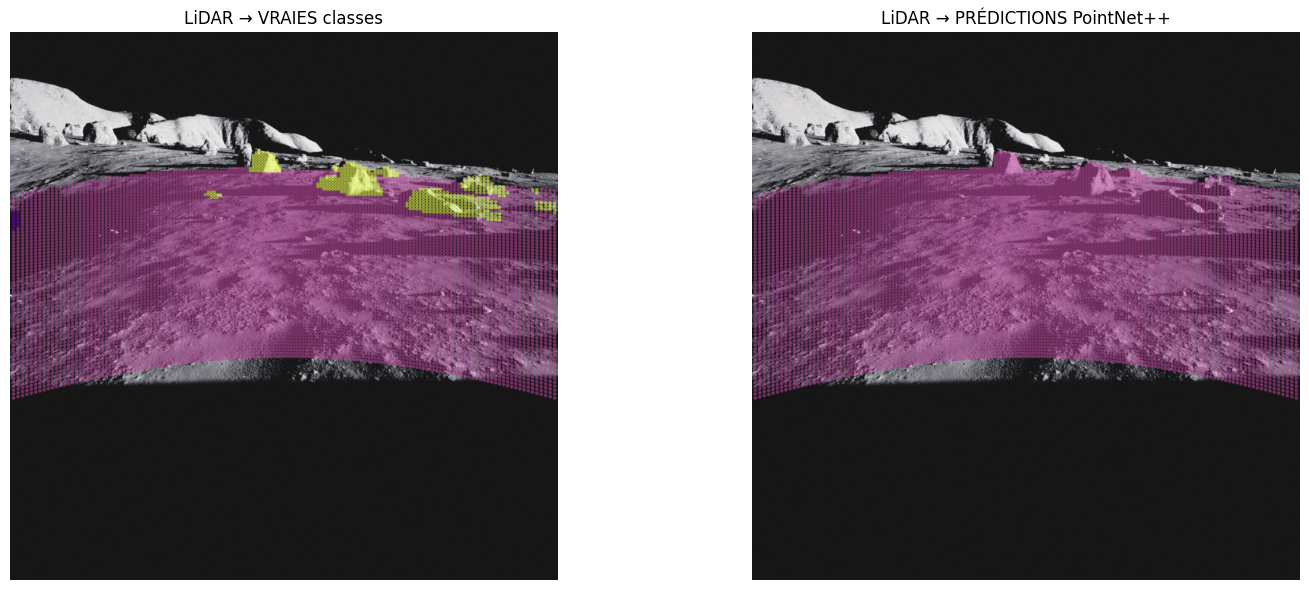

  → lidar_points : (45972, 3) | lidar_category : (45972,) | image : (1024, 1024, 3)

📊 Vraies classes :
  -   -1 (regolith) :  39648 points
  -    0 (crater) :   1824 points
  -  174 (rock) :   4500 points

🔮 Prédictions PointNet++ :
  -    0 (regolith) :  45972 points


In [62]:
device = "cpu"  # ou "cuda" si jamais tu passes au GPU
validate_npz_compare_preds(100, model, device)


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import trange

def load_npz_pair(file, remap={-1: 0, 0: 1, 174: 2}, max_points=2048):
    arr = np.load(file)
    pts = arr["lidar_points"].astype(np.float32)
    lbl = arr["lidar_category"]
    mask = np.isin(lbl, list(remap.keys()))
    pts, lbl = pts[mask], lbl[mask]  # ⚠️ filtrage d'abord
    if pts.shape[0] > max_points:
        idx = np.random.choice(len(pts), max_points, replace=False)
        pts, lbl = pts[idx], lbl[idx]
    pts = torch.tensor(pts).float()
    lbl = torch.tensor(np.vectorize(remap.get)(lbl)).long()
    return pts, lbl


# -- Config
folder = "../data/moon"
num_classes = 3
device = torch.device("cpu")
n_epochs = 10
learning_rate = 0.001
max_points = 2048

# -- Class weights (inverse freq. normalized)
weights = torch.tensor([1/180_579_595, 1/2_913_990, 1/24_663_332], dtype=torch.float)
weights = weights / weights.sum()

# -- Modèle
model = PointNet2SemSeg(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=weights)

# -- Liste des fichiers
files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])

for epoch in trange(n_epochs, desc="🧪 Entraînement"):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_seen = 0

    for f in files:
        file_path = os.path.join(folder, f)
        xyz, gt = load_npz_pair(file_path, max_points=max_points)
        print(f"→ {f} : {xyz.shape[1]} points")  # DEBUG

        xyz = xyz.unsqueeze(0).to(device)     # (1, N, 3)
        gt = gt.unsqueeze(0).to(device)       # (1, N)

        optimizer.zero_grad()
        pred = model(xyz)                     # (1, N, C)
        loss = criterion(pred.squeeze(0), gt.squeeze(0))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pred_label = pred.argmax(dim=-1)
        correct = (pred_label == gt).sum().item()
        total_correct += correct
        total_seen += gt.numel()

    acc = total_correct / total_seen
    print(f"\n📚 Epoch {epoch+1}/{n_epochs} — Loss: {epoch_loss:.4f} | Acc: {acc:.4f}")


🧪 Entraînement:   0%|          | 0/10 [00:00<?, ?it/s]

→ 1692601811687322368.npz : 3 points
→ 1692601812033751296.npz : 3 points
→ 1692601812368481792.npz : 3 points
→ 1692601812701483008.npz : 3 points
→ 1692601813034607872.npz : 3 points
→ 1692601813367551744.npz : 3 points


🧪 Entraînement:   0%|          | 0/10 [00:02<?, ?it/s]

→ 1692601813701633024.npz : 3 points


KeyboardInterrupt: 

In [77]:
def load_npz_pair(file, remap={-1: 0, 0: 1, 174: 2}, max_points=2048, verbose=True):
    arr = np.load(file)
    pts_raw = arr["lidar_points"].astype(np.float32)
    lbl_raw = arr["lidar_category"].astype(np.int64)

    if verbose:
        print(f"\n🧪 {os.path.basename(file)}")
        print(f"  - Points bruts      : {pts_raw.shape[0]}")
        print(f"  - Labels uniques    : {np.unique(lbl_raw)}")

    # filtrage
    mask = np.isin(lbl_raw, list(remap.keys()))
    pts = pts_raw[mask]
    lbl = lbl_raw[mask]

    if verbose:
        print(f"  ✅ Points après filtrage : {pts.shape[0]}")
        unique_lbl = np.unique(lbl)
        print(f"  ✅ Labels présents        : {unique_lbl}")

    if pts.shape[0] < 10:
        return None, None

    if pts.shape[0] > max_points:
        idx = np.random.choice(len(pts), max_points, replace=False)
        pts = pts[idx]
        lbl = lbl[idx]

    mapped_lbl = np.vectorize(remap.get)(lbl)
    return torch.tensor(pts).float(), torch.tensor(mapped_lbl).long()


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
from tqdm import tqdm
from collections import defaultdict

# -- Fonction de chargement
def load_npz_pair(file, remap={-1: 0, 0: 1, 174: 2}, max_points=2048):
    arr = np.load(file)
    pts_raw = arr["lidar_points"].astype(np.float32)
    lbl_raw = arr["lidar_category"].astype(np.int64)

    mask = np.isin(lbl_raw, list(remap.keys()))
    pts = pts_raw[mask]
    lbl = lbl_raw[mask]

    if pts.shape[0] < 10:
        return None, None

    if pts.shape[0] > max_points:
        idx = np.random.choice(len(pts), max_points, replace=False)
        pts = pts[idx]
        lbl = lbl[idx]

    mapped_lbl = np.vectorize(remap.get)(lbl)
    if len(set(mapped_lbl)) < 2:
        return None, None

    return torch.tensor(pts).float(), torch.tensor(mapped_lbl).long()

# -- IoU par classe
def compute_per_class_iou(pred, target, num_classes=3):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return ious

# -- Évaluation sur fichiers test
def evaluate_model(model, files, folder, max_points=2048, num_classes=3):
    model.eval()
    iou_sum = np.zeros(num_classes)
    iou_count = np.zeros(num_classes)
    total_correct = 0
    total_seen = 0

    with torch.no_grad():
        for f in files:
            path = os.path.join(folder, f)
            xyz, gt = load_npz_pair(path, max_points=max_points)
            if xyz is None:
                continue

            xyz = xyz.unsqueeze(0).to(device)
            gt = gt.unsqueeze(0).to(device)
            pred = model(xyz)
            pred_labels = pred.argmax(dim=-1)

            correct = (pred_labels == gt).sum().item()
            total_correct += correct
            total_seen += gt.numel()

            ious = compute_per_class_iou(pred_labels.squeeze(0), gt.squeeze(0), num_classes)
            for i, val in enumerate(ious):
                if not np.isnan(val):
                    iou_sum[i] += val
                    iou_count[i] += 1

    avg_acc = total_correct / total_seen if total_seen > 0 else 0.0
    class_iou = iou_sum / (iou_count + 1e-8)
    mean_iou = np.nanmean(class_iou)

    print(f"\n\U0001F4E6 Évaluation sur {len(files)} fichiers test")
    print(f"   🔸 Acc test   : {avg_acc:.4f}")
    print(f"   🔸 mIoU test  : {mean_iou:.4f}")
    for i, score in enumerate(class_iou):
        name = ["regolith", "crater", "rock"][i]
        print(f"      - {name:8} (classe {i}) → IoU = {score:.4f}")

# -- Config
folder = "../data/moon"
num_classes = 3
device = torch.device("cpu")
n_epochs = 100
learning_rate = 0.001
max_points = 2048
early_patience = 8
save_path = "best_pointnet2.pt"
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

weights = torch.tensor([
    1/180_579_595,
    1/2_913_990,
    1/24_663_332
], dtype=torch.float)
weights = weights / weights.sum()

model = PointNet2SemSeg(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=weights)

# -- Split train/test en mémoire
all_files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])
random.seed(42)
random.shuffle(all_files)
split_idx = int(0.9 * len(all_files))
train_files = all_files[:split_idx]
test_files = all_files[split_idx:]
files = train_files

# -- Entraînement
best_miou = 0.0
no_improvement = 0

for epoch in range(n_epochs):
    print(f"\n🔀 Epoch {epoch+1}/{n_epochs}")
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_seen = 0
    iou_sum = np.zeros(num_classes)
    iou_count = np.zeros(num_classes)

    for f in tqdm(files, desc=f"Epoch {epoch+1}", ncols=100):
        path = os.path.join(folder, f)
        xyz, gt = load_npz_pair(path, max_points=max_points)
        if xyz is None:
            continue

        xyz = xyz.unsqueeze(0).to(device)
        gt = gt.unsqueeze(0).to(device)

        optimizer.zero_grad()
        pred = model(xyz)
        loss = criterion(pred.squeeze(0), gt.squeeze(0))
        loss.backward()
        optimizer.step()

        pred_labels = pred.argmax(dim=-1)
        correct = (pred_labels == gt).sum().item()
        total_correct += correct
        total_seen += gt.numel()
        epoch_loss += loss.item()

        ious = compute_per_class_iou(pred_labels.squeeze(0), gt.squeeze(0), num_classes)
        for i, val in enumerate(ious):
            if not np.isnan(val):
                iou_sum[i] += val
                iou_count[i] += 1

    avg_loss = epoch_loss / len(files)
    avg_acc = total_correct / total_seen if total_seen > 0 else 0.0
    class_iou = iou_sum / (iou_count + 1e-8)
    mean_iou = np.nanmean(class_iou)

    print(f"\n📊 Résumé Epoch {epoch+1}")
    print(f"   🔹 Loss moyenne  : {avg_loss:.4f}")
    print(f"   🔹 Précision moy : {avg_acc:.4f}")
    print(f"   🔹 mIoU          : {mean_iou:.4f}")
    for i, score in enumerate(class_iou):
        name = ["regolith", "crater", "rock"][i]
        print(f"      - {name:8} (classe {i}) → IoU = {score:.4f}")

    # -- sauvegarde à chaque epoch
    epoch_model_path = os.path.join(checkpoint_dir, f"pointnet2_epoch_{epoch+1:03d}.pt")
    torch.save(model.state_dict(), epoch_model_path)

    # -- early stopping + sauvegarde best
    if mean_iou > best_miou:
        print(f"\n💾 Nouveau meilleur mIoU : {mean_iou:.4f} → sauvegarde modèle")
        torch.save(model.state_dict(), save_path)
        best_miou = mean_iou
        no_improvement = 0
    else:
        no_improvement += 1
        print(f"\n⏳ Pas d'amélioration ({no_improvement}/{early_patience})")

    if no_improvement >= early_patience:
        print(f"\n⛔ Early stopping activé — mIoU n’a pas progressé depuis {early_patience} epochs.")
        break

# -- Évaluation finale
evaluate_model(model, test_files, fold<(er)



🔀 Epoch 1/100


Epoch 1: 100%|████████████████████████████████████████████████| 4302/4302 [1:02:17<00:00,  1.15it/s]



📊 Résumé Epoch 1
   🔹 Loss moyenne  : 0.1172
   🔹 Précision moy : 0.9515
   🔹 mIoU          : 0.6531
      - regolith (classe 0) → IoU = 0.9450
      - crater   (classe 1) → IoU = 0.2486
      - rock     (classe 2) → IoU = 0.7657

💾 Nouveau meilleur mIoU : 0.6531 → sauvegarde modèle

🔀 Epoch 2/100


Epoch 2: 100%|██████████████████████████████████████████████████| 4302/4302 [28:16<00:00,  2.54it/s]



📊 Résumé Epoch 2
   🔹 Loss moyenne  : 0.0555
   🔹 Précision moy : 0.9726
   🔹 mIoU          : 0.7297
      - regolith (classe 0) → IoU = 0.9679
      - crater   (classe 1) → IoU = 0.3819
      - rock     (classe 2) → IoU = 0.8393

💾 Nouveau meilleur mIoU : 0.7297 → sauvegarde modèle

🔀 Epoch 3/100


Epoch 3: 100%|██████████████████████████████████████████████████| 4302/4302 [28:05<00:00,  2.55it/s]



📊 Résumé Epoch 3
   🔹 Loss moyenne  : 0.0448
   🔹 Précision moy : 0.9771
   🔹 mIoU          : 0.7546
      - regolith (classe 0) → IoU = 0.9729
      - crater   (classe 1) → IoU = 0.4331
      - rock     (classe 2) → IoU = 0.8578

💾 Nouveau meilleur mIoU : 0.7546 → sauvegarde modèle

🔀 Epoch 4/100


Epoch 4: 100%|██████████████████████████████████████████████████| 4302/4302 [28:12<00:00,  2.54it/s]



📊 Résumé Epoch 4
   🔹 Loss moyenne  : 0.0391
   🔹 Précision moy : 0.9797
   🔹 mIoU          : 0.7709
      - regolith (classe 0) → IoU = 0.9759
      - crater   (classe 1) → IoU = 0.4703
      - rock     (classe 2) → IoU = 0.8665

💾 Nouveau meilleur mIoU : 0.7709 → sauvegarde modèle

🔀 Epoch 5/100


Epoch 5: 100%|██████████████████████████████████████████████████| 4302/4302 [28:24<00:00,  2.52it/s]



📊 Résumé Epoch 5
   🔹 Loss moyenne  : 0.0356
   🔹 Précision moy : 0.9815
   🔹 mIoU          : 0.8015
      - regolith (classe 0) → IoU = 0.9780
      - crater   (classe 1) → IoU = 0.5501
      - rock     (classe 2) → IoU = 0.8764

💾 Nouveau meilleur mIoU : 0.8015 → sauvegarde modèle

🔀 Epoch 6/100


Epoch 6: 100%|██████████████████████████████████████████████████| 4302/4302 [28:00<00:00,  2.56it/s]



📊 Résumé Epoch 6
   🔹 Loss moyenne  : 0.0326
   🔹 Précision moy : 0.9831
   🔹 mIoU          : 0.8169
      - regolith (classe 0) → IoU = 0.9799
      - crater   (classe 1) → IoU = 0.5894
      - rock     (classe 2) → IoU = 0.8814

💾 Nouveau meilleur mIoU : 0.8169 → sauvegarde modèle

🔀 Epoch 7/100


Epoch 7: 100%|██████████████████████████████████████████████████| 4302/4302 [28:06<00:00,  2.55it/s]



📊 Résumé Epoch 7
   🔹 Loss moyenne  : 0.0299
   🔹 Précision moy : 0.9843
   🔹 mIoU          : 0.8286
      - regolith (classe 0) → IoU = 0.9813
      - crater   (classe 1) → IoU = 0.6150
      - rock     (classe 2) → IoU = 0.8895

💾 Nouveau meilleur mIoU : 0.8286 → sauvegarde modèle

🔀 Epoch 8/100


Epoch 8: 100%|██████████████████████████████████████████████████| 4302/4302 [28:07<00:00,  2.55it/s]



📊 Résumé Epoch 8
   🔹 Loss moyenne  : 0.0294
   🔹 Précision moy : 0.9848
   🔹 mIoU          : 0.8336
      - regolith (classe 0) → IoU = 0.9820
      - crater   (classe 1) → IoU = 0.6268
      - rock     (classe 2) → IoU = 0.8920

💾 Nouveau meilleur mIoU : 0.8336 → sauvegarde modèle

🔀 Epoch 9/100


Epoch 9: 100%|██████████████████████████████████████████████████| 4302/4302 [28:06<00:00,  2.55it/s]



📊 Résumé Epoch 9
   🔹 Loss moyenne  : 0.0286
   🔹 Précision moy : 0.9853
   🔹 mIoU          : 0.8462
      - regolith (classe 0) → IoU = 0.9825
      - crater   (classe 1) → IoU = 0.6602
      - rock     (classe 2) → IoU = 0.8959

💾 Nouveau meilleur mIoU : 0.8462 → sauvegarde modèle

🔀 Epoch 10/100


Epoch 10: 100%|█████████████████████████████████████████████████| 4302/4302 [56:53<00:00,  1.26it/s]



📊 Résumé Epoch 10
   🔹 Loss moyenne  : 0.0265
   🔹 Précision moy : 0.9864
   🔹 mIoU          : 0.8555
      - regolith (classe 0) → IoU = 0.9838
      - crater   (classe 1) → IoU = 0.6837
      - rock     (classe 2) → IoU = 0.8991

💾 Nouveau meilleur mIoU : 0.8555 → sauvegarde modèle

🔀 Epoch 11/100


Epoch 11: 100%|█████████████████████████████████████████████████| 4302/4302 [27:15<00:00,  2.63it/s]



📊 Résumé Epoch 11
   🔹 Loss moyenne  : 0.0273
   🔹 Précision moy : 0.9863
   🔹 mIoU          : 0.8507
      - regolith (classe 0) → IoU = 0.9836
      - crater   (classe 1) → IoU = 0.6699
      - rock     (classe 2) → IoU = 0.8984

⏳ Pas d'amélioration (1/8)

🔀 Epoch 12/100


Epoch 12: 100%|█████████████████████████████████████████████████| 4302/4302 [27:14<00:00,  2.63it/s]



📊 Résumé Epoch 12
   🔹 Loss moyenne  : 0.0252
   🔹 Précision moy : 0.9871
   🔹 mIoU          : 0.8671
      - regolith (classe 0) → IoU = 0.9846
      - crater   (classe 1) → IoU = 0.7139
      - rock     (classe 2) → IoU = 0.9028

💾 Nouveau meilleur mIoU : 0.8671 → sauvegarde modèle

🔀 Epoch 13/100


Epoch 13: 100%|█████████████████████████████████████████████████| 4302/4302 [27:14<00:00,  2.63it/s]



📊 Résumé Epoch 13
   🔹 Loss moyenne  : 0.0252
   🔹 Précision moy : 0.9871
   🔹 mIoU          : 0.8556
      - regolith (classe 0) → IoU = 0.9846
      - crater   (classe 1) → IoU = 0.6781
      - rock     (classe 2) → IoU = 0.9042

⏳ Pas d'amélioration (1/8)

🔀 Epoch 14/100


Epoch 14: 100%|█████████████████████████████████████████████████| 4302/4302 [27:09<00:00,  2.64it/s]



📊 Résumé Epoch 14
   🔹 Loss moyenne  : 0.0247
   🔹 Précision moy : 0.9873
   🔹 mIoU          : 0.8629
      - regolith (classe 0) → IoU = 0.9848
      - crater   (classe 1) → IoU = 0.6982
      - rock     (classe 2) → IoU = 0.9057

⏳ Pas d'amélioration (2/8)

🔀 Epoch 15/100


Epoch 15:  36%|█████████████████▍                               | 1535/4302 [09:43<17:31,  2.63it/s]


KeyboardInterrupt: 

In [72]:
from collections import Counter

def print_raw_label_dist(path):
    arr = np.load(path)
    raw_labels = arr["lidar_category"]
    counter = Counter(raw_labels)
    print(f"Répartition brute dans {os.path.basename(path)} :")
    for k, v in sorted(counter.items()):
        name = CATEGORY_NAMES.get(k, "???")
        print(f"  {k:>4} ({name}) : {v}")
print_raw_label_dist("../data/moon/1692601811687322368.npz")


Répartition brute dans 1692601811687322368.npz :
    -1 (regolith) : 40150
   174 (rock) : 2014
